# Settings

In [2]:
pickle_dir = '/home/erik/xams/analysis/pulse_shapes/stbc/'

# Imports

In [3]:
import numpy as np
import os

import scipy
from scipy import stats
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import odeint


from copy import deepcopy

from multihist import Hist1d, Histdd

# Default settings

In [2]:
# Digitizer sample size
dt = 2
# Pulse time for single pe sampling
dt_fine = 0.2


# Waveform time labels
spe_ts = np.linspace(0, 639*2, 640) - 340 * 2
# Valid time (because the waveform does not range the full time span)
valid_t_range = (-100, 300)
t_mask = (valid_t_range[0] <= spe_ts) & (spe_ts < valid_t_range[1])
spe_ts = spe_ts[t_mask]
spe_t_edges = np.concatenate([[spe_ts[0] - dt/2], spe_ts + dt/2])

spe_ts_fine = np.linspace(*valid_t_range, num = (valid_t_range[1] - valid_t_range[0]) / dt_fine + 1)
spe_ts_fine = spe_ts_fine[:-1]
spe_t_edges_fine = np.concatenate([[spe_ts_fine[0] - dt_fine/2], spe_ts_fine + dt_fine/2])

default_params = dict(
    t1 = 3.1,    # Singlet lifetime, Nest 2014 p2
    t3 = 24,     # Triplet lifetime, Nest 2014 p2
    fs = 0.2,    # Singlet fraction
    tts = 2.,     # Transit time spread.
    # RECOMBINATON PARAMETERS
    f_r = 0.,
    tr = 15,
    fs_r = 0.2,
    eta = 0.,
    
    s1_min=30,
    s1_max=100,
    dset='er',
    # pulse_model=1, # This is the CHANNEL that is used...
    aft = 0.5, # 0.28
    n_photons = int(2e5),
    t_min = -8.,
    t_max = 125.,
    s1_sample = 'data', # 'uniform'
    error_offset  = 0. , 
    error_pct = 0.,
    neglect_statistical = False,
    neglect_systematic = False,
    spe_model = 'template', # expnorm, hybrid?
    s1_model = 'two_exp', # recombination, recombination2
)

def get_params(params):
    '''
    Returns full set of parameters, setting the values given in `params` and setting the values in 
    `default_params` if not set explicity.
    '''
    for k, v in default_params.items(): # key, value
        params.setdefault(k, v)
    if params['tts'] < 0:
        params['tts'] = 1e-6
    # Parameters that may not be smaller than zero
    for par in ['fs', 'aft', 'f_r', 'fs_r', 'eta']:
        if params[par] < 0:
            params[par] = 0
        elif params[par] >1:
            params[par] =1
    return params

## Load PMT pulses

## Pulse shape

One of the elements of simulted S1s is the single p.e. pulse model. We extract this from the gain calibration dataset.

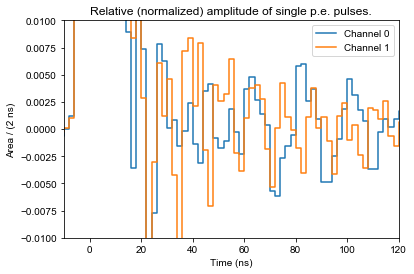

In [3]:
import pickle
from scipy.interpolate import interp1d

spe_pulses_cum = []
spe_ys = []
for ch, fn in enumerate(['170323_103732', '170323_104831']):
    with open(os.path.join(pickle_dir, '%s_ch%d.pickle' % (fn, ch)) , 'rb') as infile:
        ys = pickle.load(infile)[t_mask]
    spe_ys.append(ys/ys.sum())
    # spe_pulses_cum: list of 2 elements: cumulative distribution for two channels
    spe_pulses_cum.append(
        interp1d(spe_ts, np.cumsum(ys)/ys.sum())
    )

### Pulse shape - modified exponential

In [6]:
def exp_mod_gaus(tmin, tmax, tstep, tau, sigma, smearing_sigmas=3,  t0=0):
    '''Give a generous array for t'''
    t = np.arange(tmin, tmax, tstep)
    y_unsmeared = exp(t, tau, t0)
    
    # Maximum number of samples to go left or right
    smear_cutoff = int(np.ceil((smearing_sigmas * sigma) / tstep))
    y_arr = np.array([gaus(i * tstep, sigma) * shift_samples(y_unsmeared, i) for i in range(-smear_cutoff, smear_cutoff)])
#     for y in y_arr:
#         plt.plot(t, y)
    y = np.sum(y_arr, axis=0)
    y = y / np.sum(y) / tstep 
    
    return y
    
def exp(t, tau, t0):
    return (t >= t0) * np.exp(-(t - t0)/(tau))

def gaus(x, sigma):
    return np.exp(-0.5 * (x / sigma)**2)

def shift_samples(y, nsamples):
    '''
    Shift samples to the right (negative means left)
    '''
    if nsamples == 0:
        return y
    elif nsamples > 0:
        return np.concatenate([np.zeros(nsamples), y[:-nsamples]])
    elif nsamples < 0:
        return np.concatenate([y[ - nsamples:], np.zeros(-nsamples)])

def rebin(y, nsamples):
    if len(y) % nsamples != 0:
        raise ValueError('No es possibile')
    nbins = int(len(y) / nsamples)
    return np.average(np.reshape(y, (nbins, nsamples)), axis=1)

In [7]:
def single_pe_model(channel):
    if channel == 0:
        tau, sigma, t0_base = (5.42381418,  0.99909129,  0.60783609)
    elif channel == 1:
        tau, sigma, t0_base = (5.42609904,  0.99867648,  0.86794807)
    y_fine = exp_mod_gaus(tmin = valid_t_range[0], tmax = valid_t_range[1], tau=tau,
                          sigma = sigma, tstep = dt_fine, t0 = t0_base)
    return y_fine

## Gain variation

In [9]:
gain_params = []
for ch, fn in enumerate(['170323_103732', '170323_104831']):
    with open(os.path.join(pickle_dir, '%s_ch%d_function.pickle' % (fn, ch)) , 'rb') as infile:
        _norm, _popt, _perr = pickle.load(infile)
        gain_params.append(np.concatenate([np.array([_norm]), _popt, _perr]))
gain_params = np.array(gain_params)

In [10]:
def area_sample(n_values, gain_params, channel):
    norm, mu, sigma, _, _ = gain_params[channel]
    lower, upper = (0., 3.)
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    return X.rvs(n_values)

In [11]:
def gaus_trunc(x, mu, sigma):
    return (x > 0) * np.exp( - (x - mu)**2 / (2 * sigma**2))

# S1 model

## Recombination model

### Earlier model (WRONG AND DEPRICATED)

In [13]:
# import scipy.interpolate

# def cdf_inverse(tau, tr, tmax, nsteps = 100):
#     t = np.linspace(0, tmax, nsteps)
#     return scipy.interpolate.interp1d(cdf_r(t, tau, tr), t, bounds_error=False)

# def cdf_r(t, tau, tr):
#     lambda_s = 1/tau # lambda scintillation
#     lambda_r = 1/tr
#     A = lambda_s * lambda_r / (lambda_s - lambda_r)
#     return A * ((1/lambda_s) * (np.exp(- lambda_s * t) -1) - (1/lambda_r) * (np.exp(- lambda_r * t) -1))

# def simulate_recombination_times(nphotons, tau, tr, tmax, nsteps):
#     cdf_inv_f = cdf_inverse(tau, tr, tmax, nsteps)
#     # Check what the maximum time CDF value is
#     cdf_max = cdf_r(tmax, tau, tr)
#     if (1 - cdf_max) > 0.05:
#         print('Warning: %.2f percent of photons discarted in recombination simulation.' % ((1 - cdf_max) * 100))
#     times = cdf_inv_f(np.random.rand(nphotons) * cdf_max)
#     return times

In [14]:
# def Ir(t, tau, tr):
#     lambda_s = 1/tau # lambda scintillation
#     lambda_r = 1/tr
#     n0 = 1
#     return n0 * lambda_r * lambda_s / (lambda_s - lambda_r) * (np.exp(- lambda_r * t) - np.exp(- lambda_s * t))

In [15]:
# %%time
# times = simulate_recombination_times(2e5, 3, 15, 200, 200)

In [16]:
# t_plot = np.linspace(0, 200, 200)

# plt.hist(times, bins=500, range=(0, 200), histtype='step', normed=True, label='Simulated values')
# plt.plot(t_plot, Ir(t_plot, 3, 15), label='PDF')
# plt.plot(t_plot, Ir(t_plot, 25, 15), label='PDF')

# plt.legend()
# plt.show()

### Good model (good and not depricated)

In [17]:
def n(t, tr):
    """
    Density of ions and electrons supposing hot electron escape prob. of zero and uniform density
    """
    return 1 / (1 + t/tr)

def Ir2(t, tau, tr):
    '''The intensity of scintillation, AKA the PDF distibution for photons!'''
    if isinstance(t, float) or isinstance(t, int):
        return np.exp(-t/tau) / tau * integrate.quad(lambda x: n(x, tr)**2 * np.exp(x/tau), 0, t)[0]
    else:
        return np.array([Ir2(_t, tau, tr) for _t in t])

def Ir2_cdf(t, tau, tr):
    pdf = Ir2(t, tau, tr)
    return np.cumsum(pdf) / sum(pdf)

def Ir2_cdf_inv(t, tau, tr):
    cdf = Ir2_cdf(t, tau, tr)
    return scipy.interpolate.interp1d(cdf, t)

def simulate_recombination_times(nphotons, tau, tr, tmax, nsteps):
    t = np.linspace(0, tmax, nsteps)
    return Ir2_cdf_inv(t, tau, tr)(np.random.rand(nphotons))

### Even better model

In [67]:
def n_eta(t, tr, eta):
    params = [tr, eta]
    y0 = [(1- eta), 1]
    # print(eta)
    
    # Define the differential equations to solve
    def f(y, t, params):
        n_minus, n_plus = y
        tau, eta  = params
        alpha = 1/tau
        derivs = [- alpha * n_minus * n_plus, - alpha * n_minus * n_plus]
        return derivs
    
    psoln = odeint(f, y0, t, args=(params,))
    # Return only the electron number...
    return psoln

def n_product(t, tr, eta):
    psoln = n_eta(t, tr, eta)
    n_e = psoln[:, 0]
    n_holes = psoln[:, 1]
    return 1/ tr * n_e * n_holes


def Ir3(t, tau, tr, eta, tmax, nsteps):
    t_fine = np.linspace(0, tmax, nsteps)
    pdf = np.exp(-t_fine/tau) / tau * np.cumsum(n_product(t_fine, tr, eta) * np.exp(t_fine/tau))
    return np.interp(t, t_fine, pdf)

def Ir3_cdf(t, tau, tr, eta, tmax, nsteps):
    pdf = Ir3(t, tau, tr, eta, tmax, nsteps)
    return np.cumsum(pdf) / sum(pdf)

def Ir3_cdf_inv(t, tau, tr, eta, tmax, nsteps):
    cdf = Ir3_cdf(t, tau, tr, eta, tmax, nsteps)
    # 0 in the cdf means at time zero 
    return scipy.interpolate.interp1d(cdf, t, fill_value=(0, np.inf), bounds_error=False)

def simulate_recombination_times2(nphotons, tau, tr, eta, tmax, nsteps):
    t = np.linspace(0, tmax, nsteps)
    return Ir3_cdf_inv(t, tau, tr, eta, tmax, nsteps)(np.random.rand(nphotons))

## Simulation

In [1]:
import numba

def split_s1_groups(x, n_x, areas, channels, **params):
    """Splits x into groups with uniform (s1_min, s1_max) elements, then return matrix of histograms per group.
    Returns: integer array (n_x, n_groups)
    n_x: number of possible values in x. Assumed to be from 0 ... n_x - 1
    s1_min: minimum S1 number of hits
    s1_max: maximum S1 number of hits
    """
    params = get_params(params)
    # We want to exhaust the indices x. Simulate a generous amount of S1 sizes
    n_s1_est = int(1.5 * 2 * len(x) / (params['s1_min'] + params['s1_max']))
    
    if params['s1_sample'] == 'data' and 'xams_data' not in globals():
        print('Warning: data-derived s1 area distribution not possible, reverting to uniform...')
        params['s1_sample'] = 'uniform'
    if params['s1_sample'] == 'uniform':
        pe_per_s1 = (params['s1_max'] - params['s1_min']) * np.random.random(size=n_s1_est) + params['s1_min']
    elif params['s1_sample'] == 'data':
        # Take S1 from the data sample
        s1s_data = xams_data[params['dset']]['s1']
        s1s_data = s1s_data[(s1s_data >= params['s1_min']) & (s1s_data < params['s1_max'])]
        pe_per_s1  = np.random.choice(s1s_data, size=n_s1_est)
    else:
        raise ValueError('Configuration not understood, got this: ', params['s1_sample'])
    # These are two arrays for the two channels
    # i.e. these will later yield the top and bottom waveform
    result0 = np.zeros((n_x, n_s1_est), dtype=float)
    result1 = np.zeros((n_x, n_s1_est), dtype=float)
    s1_i = _split_s1_groups(x, pe_per_s1, result0, result1, areas, channels)
    return result0[:,:s1_i - 1], result1[:,:s1_i - 1]


@numba.jit(nopython=True)
def _split_s1_groups(x, pe_per_s1, result0, result1, areas, channels):
    # One of these days, I'm going to cut you into little pieces
    s1_i = 0
    for photon_i, (i, ch) in enumerate(zip(x, channels)):
        if pe_per_s1[s1_i] < 0:
            s1_i += 1
            continue
        if ch == 0:
            result0[i, s1_i] += areas[photon_i]
        if ch == 1:
            result1[i, s1_i] += areas[photon_i]
        pe_per_s1[s1_i] -= areas[photon_i]
    return s1_i 

# %%timeit
# split_s1_groups(np.random.randint(0, 100, size=int(1e6)), 101, 10, 20)

def shift(x, n):
    """Shift the array x n samples to the right, adding zeros to the left."""
    if n > 0:
        return np.pad(x, (n, 0), mode='constant')[:len(x)]
    else:
        return np.pad(x, (0, -n), mode='constant')[-len(x):]



def simulate_s1_pulse(**params):
    # n_photons=int(2e5), 
    """Return (wv_matrix, time_matrix, t_shift vector) for simulated S1s, consisting of n_photons in total
    """
    params = get_params(params)
    n_photons = params['n_photons']

    ##
    # Make matrix (n_samples, n_waveforms) of pulse waveforms with various shifts
    ##
    wv_matrix_list = []
    for ch in [0, 1]:
        # This is a matrix filled with waveforms, ordered by their SHIFT.
        # So, these are all just model waveforms and will be selected later
        if params['spe_model'] == 'template':
            y = spe_ys[ch]  # This is the CHANNEL
            i_noshift = np.searchsorted(spe_t_edges, [0])[0]    # Index corresponding to no shift in the waveform
            wv_matrix = np.vstack([shift(y, i - i_noshift) 
                               for i in range(len(spe_ts))]).T 
        elif params['spe_model'] == 'expnorm':            
            y = single_pe_model(ch)
            i_noshift = np.searchsorted(spe_t_edges_fine, [0])[0]    # Index corresponding to no shift in the waveform
            wv_matrix = np.vstack([rebin(shift_samples(y, i - i_noshift), int(dt / dt_fine))
                               for i in range(len(spe_ts_fine))]).T 
        else:
            raise ValueError('spe model not understood')
        wv_matrix_list.append(wv_matrix)
    
    ##
    # Simulate S1 pulse times, convert to index
    ##

    # Channel selector
    n_top = np.random.binomial(n=n_photons, p=params['aft']) # Number of photons happening in top array
    # First all the top channels, then all the bottom channels (ch1)
    channels = np.concatenate([np.zeros(n_top, dtype=int), np.ones(n_photons - n_top, dtype=int)])
    areas = np.concatenate([area_sample(n_top, gain_params, channel=0), 
                            area_sample(n_photons - n_top, gain_params, channel=1)])
    # Shuffle the two lists the exact same way
    channels, areas = unison_shuffled_copies(channels, areas)
    
    # Time is distributed according to exponential distribution
    # This is the TRUE time of all the photons generated, assuming time=0  is the time of the interaction
    times = np.zeros(n_photons)

    if params['s1_model'] == 'two_exp':
        n_singlets = np.random.binomial(n=n_photons, p=params['fs']) # We randomly select if the photon came from a 
                                                                     # singlet or triplet decay
        times += np.concatenate([
            np.random.exponential(params['t1'], n_singlets),
            np.random.exponential(params['t3'], n_photons - n_singlets)
        ])
    elif params['s1_model'] == 'recombination' or params['s1_model'] == 'recombination2':
        n_recombination = np.random.binomial(n=n_photons, p=params['f_r'])
        n_recombination_singlets = np.random.binomial(n=n_recombination, p=params['fs_r'])
        n_recombination_triplets = n_recombination - n_recombination_singlets
        n_direct = n_photons - n_recombination
        n_direct_singlets = np.random.binomial(n=n_direct, p=params['fs'])
        n_direct_triplets = n_direct - n_direct_singlets
        assert (n_recombination_singlets + n_recombination_triplets + n_direct_singlets + n_direct_triplets == n_photons)        
        if params['s1_model'] == 'recombination':
            times += np.concatenate([
                np.random.exponential(params['t1'], n_direct_singlets),
                np.random.exponential(params['t3'], n_direct_triplets),
                simulate_recombination_times(n_recombination_singlets, params['t1'], params['tr'], 250, 500), 
                simulate_recombination_times(n_recombination_triplets, params['t3'], params['tr'], 250, 500), 
            ])
        elif params['s1_model'] == 'recombination2':
            times += np.concatenate([
                np.random.exponential(params['t1'], n_direct_singlets),
                np.random.exponential(params['t3'], n_direct_triplets),
                simulate_recombination_times2(n_recombination_singlets, params['t1'], params['tr'], params['eta'],
                                              250, 1251), 
                simulate_recombination_times2(n_recombination_triplets, params['t3'], params['tr'], params['eta'],
                                              250, 1251), 
            ])    
    else:
        raise ValueError('S1 model type not understood, got this: %s' % params['s1_model'])
        
        
        
    # Since `times` is now sorted in (singlet, triplet), shuffle them
    np.random.shuffle(times)
    
    # Here we start taking into account detector physics: the transit time spread (simulated as normal dist.)
    times += np.random.normal(0, params['tts'], size=n_photons)
    
    # Find the bin that the photon would be in if it were sampled.
    # Now, we delete all the photons that are outside of the bin range and re-match to the bin centers
    # (Check the searchsorted documentation)
    if params['spe_model'] == 'template':
        indices = np.searchsorted(spe_t_edges, times)
        indices = indices[~((indices == 0) | (indices == len(spe_t_edges)))] - 1
    elif params['spe_model'] == 'expnorm':
        indices = np.searchsorted(spe_t_edges_fine, times)
        indices = indices[~((indices == 0) | (indices == len(spe_t_edges_fine)))] - 1



    # This is the new amount of photons simulated
    if len(indices) < n_photons:
        # print('Warning: I just threw away %d photons...' % (n_photons - len(indices)))
        n_photons = len(indices)
    
    ##
    # Build instruction matrix, simulate waveforms
    ##
    # So far, we've just been simulating a bunch of photons (very many).
    # We are now going to split this into S1s: the split will be made at a random point between s1_min and s1_max.
    # `index_matrix` is a matrix split into groups forming S1s. 
    # We've got two for the two channels    
    if params['spe_model'] == 'template':
        index_matrix0, index_matrix1 = split_s1_groups(indices, len(spe_t_edges) - 1, areas,channels, **params)
    elif params['spe_model'] == 'expnorm':
        index_matrix0, index_matrix1 = split_s1_groups(indices, len(spe_t_edges_fine) - 1, areas,channels, **params)

    # Now, index_matrix[:, 0] contains a list of number of entries for the shift for each timestamp in bin
    n_s1 = index_matrix0.shape[1]
    
    # Remember that wv_matrix is a matrix of waveforms, each element at position i of which is shifted i samples
    s1_waveforms = np.dot(wv_matrix_list[0], index_matrix0) + np.dot(wv_matrix_list[1], index_matrix1)
    # return s1_waveforms

    ##
    # Alignment based on maximum sample, compute average pulse
    ##
    time_matrix, t_shift = aligned_time_matrix(spe_ts, s1_waveforms)    
    return s1_waveforms, time_matrix, t_shift

def aligned_time_matrix(ts, wv_matrix, mode = '10p'):
    """Return time matrix that would align waveforms im wv_matrix"""
    n_s1 = wv_matrix.shape[1]

    if mode == 'max':
        # Find the position of maximum sample and match its times
        t_shift = ts[np.argmax(wv_matrix, axis=0)]
    elif mode == '10p':
        fraction_reached = np.cumsum(wv_matrix, axis=0) / np.sum(wv_matrix, axis=0)
        # Get the sample where 10% is reached by taking the sample closest to the 10% point
        # This is as good as you can get without introducing fractional samples (which may be an improvement)
        # TODO get interpolation in here
        distance_to_10p_point = np.abs(fraction_reached - 0.1)
        t_shift = ts[np.argmin(distance_to_10p_point, axis=0)]
    
    time_matrix = np.repeat(ts, n_s1).reshape(wv_matrix.shape)
    time_matrix -= t_shift[np.newaxis,:]
    return time_matrix, t_shift

def average_pulse(time_matrix, wv_matrix):
    """Return average pulse, given time and waveform matrices"""
    h, _ = np.histogram(time_matrix, bins=spe_t_edges, weights=wv_matrix)
    h /= h.sum()
    return h

def s1_average_pulse_model(*args, **kwargs):
    wv_matrix, time_matrix, _ = simulate_s1_pulse(*args, **kwargs)
    return average_pulse(time_matrix, wv_matrix)

def unison_shuffled_copies(a, b):
    '''Stack overflow to the rescue'''
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Here we simulate statistical errors by simulating `n_data_s1s` and then performing bootstrap trials. The conclusion:....

The errors are small but still interesting. We perform the bootstrapping on DATA instead, see later on...

In [23]:
def s1_models_resample(*args, n_data_s1s=1000, bootstrap_trials=10, **kwargs):
    """Return bootstrap_trials waveform templates from sampling n_data_s1s s1s"""
    wv_matrix, time_matrix, _ = simulate_s1_pulse(*args, **kwargs)
    n_s1s = wv_matrix.shape[1]
    
    waveform_templates = np.zeros((len(spe_ts), bootstrap_trials))

    for i in range(bootstrap_trials):
        new_indices = np.random.randint(n_s1s, size=n_data_s1s)

        waveform_templates[:, i] = average_pulse(time_matrix[:, new_indices], 
                                                 wv_matrix[:, new_indices])
    
    return waveform_templates

def sigmas_plot(x, q, color='b', **kwargs):
    for n_sigma, alpha in [(1,0.5), (2, 0.1)]:
        plt.fill_between(x,
                         np.percentile(q, 100 * stats.norm.cdf(-n_sigma), axis=1),
                         np.percentile(q, 100 * stats.norm.cdf(n_sigma), axis=1),
                         alpha=alpha, linewidth=0, color=color, step='mid')
    plt.plot(x, 
             np.percentile(q, 50, axis=1), 
             color=color, linestyle='-', alpha=0.5, linewidth=1, **kwargs)

## Systematic errors

In [25]:
import itertools
import math
def s1_models_error(*args, shifts=None, mode='std', **kwargs):
    '''
    Compute the error on the S1 waveform given errors on specific parameters.
    This will compute the S1 model for parameter +error, +0, and -error.
    All combinations of parameters are tried.
    `shifts` is a dict containting the allowed shift (+/-) for each model parameter.
    `*args` and `**kwargs` will be passed to `s1_average_pulse_model` to compute the base model.
    This function can also be used for getting the difference in pulse model for channel 0 and 1.
    '''
    if kwargs.get('neglect_systematic', default_params['neglect_systematic']):
        base_model = s1_average_pulse_model(*args, **kwargs)
        return base_model, base_model, base_model
    
    
    if shifts is None:
        # Default uncertainty: in pulse model and in TTS
        shifts = dict(tts=0.5, aft=0.5)
    
    # Allow specifying a single +- amplitude of variation
    for p, shift_values in shifts.items():
        if isinstance(shift_values, (float, int)):
            shifts[p] = kwargs.get(p, default_params[p]) + np.array([-1, 0, 1]) * shift_values
    

    shift_pars = sorted(shifts.keys())
    shift_values = [shifts[k] for k in shift_pars]
    # shift_value_combs is a list of paramters that will be tried to compute the average pulse.
    # Contains all combintations: (+, 0, -) for all the parameters. ((3n)^2 for n number of parameters.)
    shift_value_combs = list(itertools.product(*shift_values))
    noshift_comb = tuple([(kwargs.get(p, default_params[p])) for p, shift_values in shifts.items()])
    noshift_index = int((len(shift_value_combs) -1) /2)
    # Check if we have the right index
    
    for i, comb in enumerate(shift_value_combs):
        if np.all([np.isclose(a,b) for a, b in zip(comb, noshift_comb)]):
            noshift_index = i
        
        
    # for a, b in zip(noshift_comb, shift_value_combs[noshift_index]):
        
    
    alt_models = []
    for vs in shift_value_combs:
        kw = dict()
        kw.update(kwargs)
        for i, p in enumerate(shift_pars):
            kw[p] = vs[i]        
        alt_models.append(s1_average_pulse_model(*args, **kw))
    
    
    alt_models = np.vstack(alt_models)
    base_model = alt_models[noshift_index]
    # Hmmm. this seems like an upper estimate of the error, no?
    # ask jelle
    # return alt_models
    if mode == 'extreme':
        minus = np.min(alt_models, axis=0)
        plus = np.max(alt_models, axis=0)
    elif mode == 'std':
        sigma_sys = np.std(alt_models, axis=0)
        minus = base_model - sigma_sys
        plus = base_model + sigma_sys
    else:
        raise ValueError('Mode %s not known' % mode)
    
    return minus, base_model, plus
    

# Real data waveforms

## Read the data

Here we read the S1 data for three (highfield) datasets: NR, ER and BG_NR. We store it in the form of a dict (keys: er, nr, bg_nr). Each dict item is an array containing the waveforms (per row).

In [27]:
xams_data = dict()
xams_data['nr'], xams_data['er'], xams_data['bg_nr'] = pickle.load(open(os.path.join(pickle_dir, 
                                                                                     'highfield_dataframes_new.pickle'),'rb'))
xams_data['er_0'] = pickle.load(open(os.path.join(pickle_dir, 'zerofield_dataframes_temp.pickle'), 'rb'))
xams_data['nr_l'], xams_data['er_l'] = pickle.load(open(os.path.join(pickle_dir, 'lowfield_dataframes.pickle'), 'rb'))
xams_s1s = dict()
# Get pulse waveforms to matrix rather than object column
for k, d in xams_data.items():
    xams_s1s[k] = np.array([x for x in d['s1_pulse']])
    del d['s1_pulse']

Here's an example waveform

For now use 0.28 +- 0.12 as uncertainty of the fit

## Alignment, averaging, bootstrapping

In [30]:
def real_s1_wv(**params):
    """Return average S1 waveform, number of S1s it was constructed from"""
    params = get_params(params)
    
    areas = xams_data[params['dset']]['s1'].values
    mask = (params['s1_min'] < areas) & (areas < params['s1_max'])

    # Could now derive distribution, I'll just assume uniform for the moment.
    # Hist1d(areas[mask],
    #        bins=np.linspace(params['s1_min'], params['s1_max'], 100)).plot()

    n_data_s1s = mask.sum()
    wvs = xams_s1s[params['dset']][mask].T
    tmat, _ = aligned_time_matrix(spe_ts, wvs)
    real_s1_avg =  average_pulse(tmat, wvs)
    
    return real_s1_avg, n_data_s1s

In [31]:
def real_s1_wv_sigma(bootstrap_trials = 25, **params):
    """Take data S1s, bootstrap sample, then check what the variance is"""
    params = get_params(params)
    
    time_matrix, wv_matrix = real_s1_wv_matrix(**params)
    n_s1s = wv_matrix.shape[1]
    waveform_templates = np.zeros((len(spe_ts), bootstrap_trials))

    for i in range(bootstrap_trials):
        new_indices = np.random.randint(n_s1s, size=n_s1s)

        waveform_templates[:, i] = average_pulse(time_matrix[:, new_indices], 
                                                 wv_matrix[:, new_indices])
        
    
    return np.std(waveform_templates, axis=1)

In [32]:
def real_s1_wv_matrix(**params):
    """Return the aligned time matrix and waveform matrix."""
    params = get_params(params)
    
    areas = xams_data[params['dset']]['s1'].values
    mask = (params['s1_min'] < areas) & (areas < params['s1_max'])

    # Could now derive distribution, I'll just assume uniform for the moment.
    # Hist1d(areas[mask],
    #        bins=np.linspace(params['s1_min'], params['s1_max'], 100)).plot()

    n_data_s1s = mask.sum()
    wvs = xams_s1s[params['dset']][mask].T
    tmat, _ = aligned_time_matrix(spe_ts, wvs)
        
    return tmat, wvs

# Model-data comparison

## Sigma and residuals

In [36]:
def residuals(ydata, minus, base, plus, **params):
    params = get_params(params)
    sigma = get_sigma(minus, base, plus, **params)
    if 0. in sigma:
        zero_positions = np.where(sigma == 0)
        print('Warning: found zero in error array at positions: ', zero_positions)
        print('Replacing with infinite error instead...')
        for pos in zero_positions:
            sigma[pos] = np.inf
    return (ydata - base) / sigma

def get_sigma(minus, base, plus, **params):
    params = get_params(params)
    if (np.any(minus > base) | np.any(base > plus)):
        raise ValueError('Screw this, negative errors should not be there!')
    sigma_syst = np.abs(plus - minus)/2 + params['error_offset'] + params['error_pct'] * np.abs(base)
    if params['neglect_statistical']:
        print('Neglect!')
        return sigma_syst
    sigma_stat = real_s1_wv_sigma(bootstrap_trials = 25, **params)
    sigma = np.sqrt(sigma_syst**2 + sigma_stat**2)
    return sigma
   

## Plotting

In [58]:
def comparison_plot(ydata, minus, base, plus, log=False, **params):
    params = get_params(params)
    sigmas = get_sigma(minus, base, plus, **params)

    # large subplot
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

    #f, (ax1, ax2) = plt.subplots(2, sharex=True)
    plt.sca(ax1)
    # plt.fill_between(spe_ts, minus, plus, alpha=0.5, linewidth=0, step='mid')
    plt.fill_between(spe_ts, base - sigmas, base + sigmas,
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, base, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=0.1, linestyle='-', which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    leg = plt.legend(loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    if log:
        plt.yscale('log')
        plt.ylim(1e-5, 1e-1)
    else:
        plt.ylim(0, None)

    #ax1.set_xticklabels([])

    # Add residuals
    plt.sca(ax2)
    plt.subplot2grid((3,1), (2,0), sharex=ax1)
    plt.xlim(params['t_min'], params['t_max'])

    res = residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res,
             linestyle='', marker='x', c='k', markersize=3)
    plt.ylim(-3, 3)
    plt.grid(which='both', linestyle='-', alpha=0.1)
    plt.axhline(0, c='k', alpha=0.5)

    plt.ylabel("Residual")
    plt.xlabel("Time since alignment point")
#     plt.text(#plt.xlim()[1] * 0.5, plt.ylim()[1] * 0.6,
#              60, 2,
#              'Mean abs. res.: %0.3f' % np.abs(res).mean())

    plt.tight_layout()
    plt.gcf().subplots_adjust(0,0,1,1,0,0)

def comparison_plot_2(ydata, minus, base, plus, plot_residual = True, **params):
    params = get_params(params)
    res = residuals(ydata, minus, base, plus, **params)
    sigmas = get_sigma(minus, base, plus, **params)
    
#     plt.fill_between(spe_ts, minus - params['error_offset'], plus + params['error_offset'],
#                      alpha=0.5, linewidth=0, step='mid')
    plt.fill_between(spe_ts, base - sigmas, base + sigmas,
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, base, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')
    plt.yscale('log')
    plt.ylim(2e-5, 1e-1)
    plt.ylabel("Fraction of amplitude")
    plt.xlabel('Time (ns)')
    for _l in (params['t_min'], params['t_max']):
        plt.axvline(_l, ls='dotted', color='black')
    if plot_residual:
        plt.twinx()
        plt.plot(spe_ts, np.abs(res), color='red')
        plt.ylabel('Residual / error')
        plt.ylim(0)
    plt.xlim(params['t_min'] - 20, params['t_max'] + 50)
    
    res = res[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])]
    chi2 = sum(res**2) / len(spe_ts[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])])
    print('chi2 = %f' % chi2)
    
def plot_model(plot_type = 0, figname = None, plot_residual = True, **params):
    params = get_params(params)
    print(params)
    ydata, _ = real_s1_wv(**params)
    minus, base, plus = s1_models_error(**params)
    if plot_type == 0 or plot_type == 1:
        comparison_plot(ydata, minus, base, plus, **params)
        if figname is not None:
            plt.savefig('figs/' + figname + '_1.png', bbox_inches = 'tight', dpi = 400)
        plt.show()
    if plot_type == 0 or plot_type == 2:
        comparison_plot_2(ydata, minus, base, plus, plot_residual = plot_residual, **params)
        if figname is not None:
            plt.savefig('figs/' + figname + '_2.png', bbox_inches = 'tight', dpi = 400)

        plt.show()
    return

## Residuals function

In [38]:
def gof(verbose=True, mode = 'chi2_ndf', **params):
    '''
    Get the value to minimize given the parameters
    '''
    params = get_params(params)
    # Do not allow unphysical values
    if params['t1'] < 0 or params['t3'] < 0 or not (0 <= params['fs'] <= 1):
        result = float('inf')
    else:
        ydata, _ = real_s1_wv(**params)
        minus, base, plus = s1_models_error(**params)
        res = residuals(ydata, minus, base, plus, **params)
        assert len(res) == len(spe_ts)
        res = res[(spe_ts >= params['t_min']) & (spe_ts < params['t_max'])]
        if mode == 'mean':
            result = np.abs(res).mean()
        elif mode == 'median':
            result = np.median(np.abs(res))
        elif mode == 'chi2':
            result = np.sum(res**2)
        elif mode == 'chi2_ndf':
            result = 1/len(res) * np.sum(res**2)
        elif mode == 'res':
            result = res
        else:
            raise ValueError('Mode unknown, got this: %s' % mode)
    if verbose and (mode != 'res'):
        print('gof={gof}, fs={fs}, t1={t1}, t3={t3}, tts={tts}'.format(gof=result, **params))
    return result

def gof_repeat(iterations, verbose=True, mode = 'chi2_ndf', metamode = 'median', **params):
    params = get_params(params)
    if params['t1'] < 0 or params['t3'] < 0 or not (0 <= params['fs'] <= 1):
        result = float('inf')
    else:
        gofs = np.array([gof(verbose=False, mode = mode, **params) for _ in range(iterations)])
        if metamode == 'median':
            result = np.median(gofs)
        elif metamode == 'mean':
            result = np.mean(gofs)
    if verbose:
        print('gof={gof}, fs={fs}, t1={t1}, t3={t3}, tts={tts}'.format(gof=result, **params))
    return result    


In [39]:
def gof_simultaneous(fs_er, fs_nr, verbose=True, mode='mean', **params):
    params = get_params(params)
    params_er = deepcopy(params)
    params_nr = deepcopy(params)
    params_er['dset'] = 'er'
    params_nr['dset'] = 'nr'
    params_er['fs'] = fs_er
    params_nr['fs'] = fs_nr
    gof_er = gof(verbose=False, mode=mode, **params_er)
    gof_nr = gof(verbose=False, mode=mode, **params_nr)
    if verbose:
        print('gof_er={gof_er}, gof_nr={gof_nr}, fs_er={fs_er}, fs_nr={fs_nr} t1={t1}, t3={t3}, tts={tts}'.format(
            gof_er=gof_er, gof_nr=gof_nr, fs_er = params_er['fs'], fs_nr = params_nr['fs'], **params))    
    return gof_er + gof_nr

In [40]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

def minimize_it(param_names, starting_values, **params):
    optresult = optimize.minimize(
        lambda x: gof(**merge_two_dicts(params, {par : x[i] for i, par in enumerate(param_names)})),
        starting_values,
        options=dict(maxfev=1000),
        method='Powell',
    )
    return optresult

### Combined fit

In [ ]:
def check_combined_model(Linf, plot=False, plot_type = 1, **p):
    # Extract the recombination fractions from Linf
    if Linf > 143:
        return np.inf
    dsets_er = ['er_0', 'er_l', 'er']
    L = [200, 168, 143] # light yield for 0, 100 and 500 field
    frs = [l / Linf -1 for l in L]
    gofs = [] 
    for dset, fr in zip(dsets_er, frs):
        p['dset'] = dset
        p['f_r'] = fr
        if plot:
            plot_model(plot_type=plot_type, **p)
        gofs.append(gof(**p))
    print(gofs)
    # Add penalties!
    # Linf, t3, fs
#     guess_values = [130, 23, 0.25]
#     sigmas = [5, 2, 0.5]
#     prior_Linf = [1/gaus(Linf - guess_values[0], sigmas[0])]
#     prior_thingy = [1/gaus(p[param] - guess_values[i + 1], sigmas[i + 1]) for i, param in enumerate(['t3', 'fs'])]
#     prior_thingy = prior_Linf + prior_thingy
#     print(prior_thingy)
    
    return sum(gofs) #  + sum(prior_thingy)